# Uploading the zipped dataset and unzipping it .


In [1]:
from google.colab import files
import zipfile

uploaded = files.upload()  # Select your `Kvasir-SEG.zip` file

# if 'kvasir-SEG.zip' in uploaded:
with zipfile.ZipFile('kvasir-seg.zip', 'r') as zip_ref:
        zip_ref.extractall('Kvasir-SEG')  # Unzips into /content/Kvasir-SEG/
        # print("Dataset ready at /content/Kvasir-SEG/")
# else:
#     print("Upload failed. Ensure the file is named correctly.")

Saving kvasir-seg.zip to kvasir-seg.zip


# Installing dependencies

In [2]:
!pip install torch torchvision albumentations segmentation-models-pytorch --quiet
!pip install -U git+https://github.com/albumentations-team/albumentations --quiet  # Latest version

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 15.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.t

# Importing needed libraries

In [3]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch
from tqdm import tqdm
import torch.optim as optim

# Accelerate OpenCV with GPU
cv2.setUseOptimized(True)
cv2.setNumThreads(4)

# Preprocessing dataset

In [4]:

# Dataset Class
class PolypDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Use OpenCV's GPU-accelerated loading (if available)
        image = cv2.cvtColor(cv2.imread(self.images[idx], cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)

        # Normalize and convert to tensor
        image = image.astype(np.float32) / 255.0
        mask = (mask > 127).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Move to channel-first format
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image, mask


# As we have less dataset , we are doing data Augmentation

In [5]:
# Data Augmentation
train_transform = A.Compose([
    A.Resize(256, 256, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.GridDistortion(p=0.2),
    A.MedianBlur(blur_limit=3, p=0.1),
], is_check_shapes=False)

val_transform = A.Compose([
    A.Resize(256, 256, interpolation=cv2.INTER_NEAREST),
], is_check_shapes=False)


# Splitting the dataset into Train , Test and Val

In [6]:
# Load dataset paths
image_dir = "/content/Kvasir-SEG/Kvasir-SEG/images"
mask_dir = "/content/Kvasir-SEG/Kvasir-SEG/masks"

images = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
masks = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.jpg')])

# Splitting data (70-15-15)
train_images, test_images, train_masks, test_masks = train_test_split(
    images, masks, test_size=0.3, random_state=42
)
val_images, test_images, val_masks, test_masks = train_test_split(
    test_images, test_masks, test_size=0.5, random_state=42
)

# Creating datasets
train_dataset = PolypDataset(train_images, train_masks, train_transform)
val_dataset = PolypDataset(val_images, val_masks, val_transform)
test_dataset = PolypDataset(test_images, test_masks, val_transform)

# Creating dataloaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)

In [7]:
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 700, Val: 150, Test: 150


# Visualizing the images with masked images

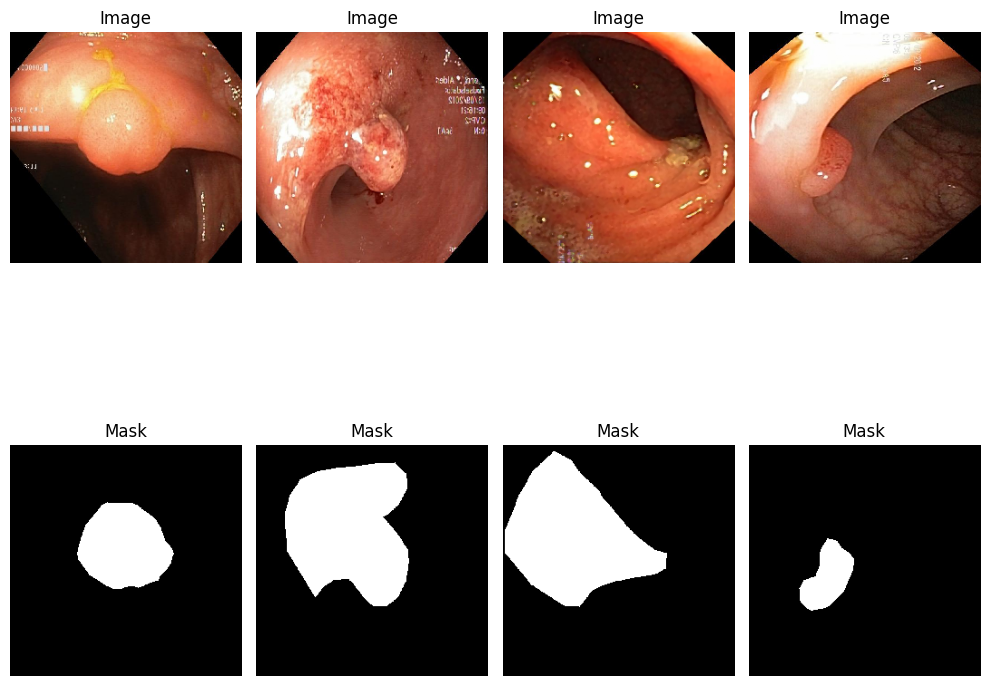

In [8]:
# Visualize a batch
def show_batch(batch):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        plt.subplot(2, 4, i+1)
        plt.imshow(batch[0][i].permute(1, 2, 0))
        plt.title("Image")
        plt.axis('off')
        plt.subplot(2, 4, i+5)
        plt.imshow(batch[1][i].squeeze(), cmap='gray')
        plt.title("Mask")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show first batch
for batch in train_loader:
    show_batch(batch)
    break


# Defining model , we are going to do pre-trained learning

In [9]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize U-Net with efficientnet-b4 pretrained on ImageNet
model = smp.Unet(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid",               # Good for binary masks
    decoder_attention_type="scse"       # SCSE attention is supported
).to(device)

print(f"Model loaded on {device}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Model loaded on cuda


# Combining Two losses : Dice and BCE

In [10]:
# Enhanced Loss Function
class EnhancedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice = smp.losses.DiceLoss(mode='binary')
        self.focal = smp.losses.FocalLoss(mode='binary')
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, outputs, targets):
        return 0.5*self.dice(outputs, targets) + 0.3*self.focal(outputs, targets) + 0.2*self.bce(outputs, targets)

criterion = EnhancedLoss()
metrics = {
    'dice': smp.metrics.f1_score,
    'iou': smp.metrics.iou_score,
    'precision': smp.metrics.precision,
    'recall': smp.metrics.recall
}
# Optimizer with Weight Decay
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)


# Training and Validating

In [11]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)

    for images, masks in progress_bar:
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])

    return running_loss / len(loader)

def validate_epoch(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    metric_values = {name: 0.0 for name in metrics.keys()}

    with torch.no_grad():
        progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]", leave=False)
        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            val_loss += criterion(outputs, masks).item()

            # Dynamic thresholding and type conversion
            threshold = 0.5 + (0.7 - 0.5) * (epoch / NUM_EPOCHS)
            outputs = (torch.sigmoid(outputs) > threshold).float()
            masks = masks.long()

            # Convert to integer type for get_stats
            outputs_int = outputs.round().byte()  # Convert to 0/1 integer values
            masks_int = masks.byte()

            tp, fp, fn, tn = smp.metrics.get_stats(outputs_int, masks_int, mode='binary', threshold=None)
            metric_values['dice'] += smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
            metric_values['iou'] += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            metric_values['precision'] += smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
            metric_values['recall'] += smp.metrics.recall(tp, fp, fn, tn, reduction="micro")

            progress_bar.set_postfix({k: f"{v/(progress_bar.n+1):.4f}" for k, v in metric_values.items()})

    # Average metrics
    val_loss /= len(loader)
    for name in metric_values:
        metric_values[name] /= len(loader)

    return val_loss, metric_values

# Training loop for model training

In [12]:
NUM_EPOCHS = 5
best_dice = 0.0

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    total_steps=NUM_EPOCHS * len(train_loader),
    pct_start=0.3,
    anneal_strategy='cos'
)

for epoch in range(NUM_EPOCHS):
    # Training
    train_loss = train_epoch(model, train_loader, optimizer, criterion)

    # Validation
    val_loss, val_metrics = validate_epoch(model, val_loader, criterion)

    # Print stats
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} Summary:")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Dice: {val_metrics['dice']:.4f} | IoU: {val_metrics['iou']:.4f}")
    print(f"Precision: {val_metrics['precision']:.4f} | Recall: {val_metrics['recall']:.4f}")
    print("-" * 50)

    # Save best model
    if val_metrics['dice'] > best_dice:
        best_dice = val_metrics['dice']
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'best_dice': best_dice,
        }, "best_model.pth")
        print(f"best model saved (Dice: {best_dice:.4f})")


Epoch 1/5 Summary:
Train Loss: 0.6593 | Val Loss: 0.5989
Dice: 0.2686 | IoU: 0.1561
Precision: 0.1561 | Recall: 1.0000
--------------------------------------------------
best model saved (Dice: 0.2686)



Epoch 2/5 Summary:
Train Loss: 0.5718 | Val Loss: 0.5424
Dice: 0.7955 | IoU: 0.6629
Precision: 0.7252 | Recall: 0.8868
--------------------------------------------------
best model saved (Dice: 0.7955)



Epoch 3/5 Summary:
Train Loss: 0.5382 | Val Loss: 0.5404
Dice: 0.7734 | IoU: 0.6340
Precision: 0.7889 | Recall: 0.7772
--------------------------------------------------



Epoch 4/5 Summary:
Train Loss: 0.5305 | Val Loss: 0.5273
Dice: 0.8725 | IoU: 0.7764
Precision: 0.8794 | Recall: 0.8732
--------------------------------------------------
best model saved (Dice: 0.8725)



Epoch 5/5 Summary:
Train Loss: 0.5279 | Val Loss: 0.5249
Dice: 0.8865 | IoU: 0.7982
Precision: 0.9175 | Recall: 0.8624
--------------------------------------------------
best model saved (Dice: 0.8865)


# Finally evaluating the model

Loaded best model for testing.


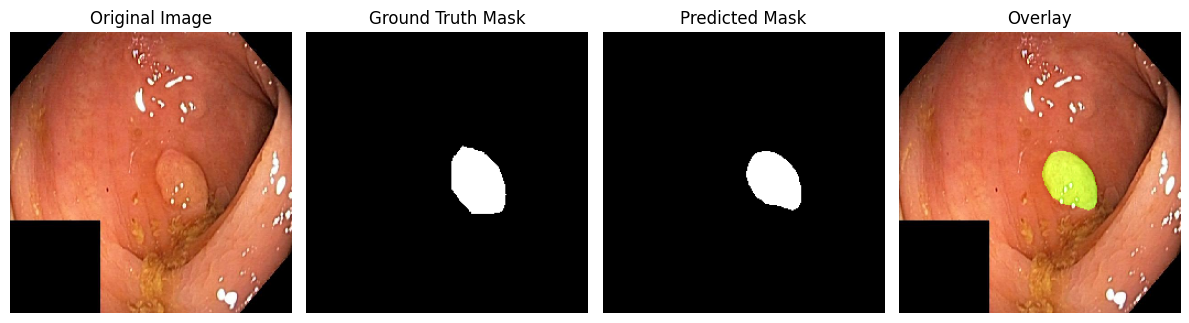

In [17]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch

# Load the best saved model
checkpoint = torch.load("best_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Loaded best model for testing.")

# Get a random batch from the test loader
test_batch = next(iter(test_loader))
images, masks = test_batch

# Pick a random index from the batch
idx = random.randint(0, len(images) - 1)
image = images[idx].unsqueeze(0).to(device)  # Add batch dimension
true_mask = masks[idx].squeeze().cpu().numpy()

# Get prediction
with torch.no_grad():
    pred_mask = model(image)
    pred_mask = pred_mask.squeeze().cpu().numpy()

# Threshold prediction if using sigmoid
pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

# Convert original tensor image to numpy
image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize

# Overlay mask on image
overlay = image_np.copy()
overlay[..., 1] += pred_mask_bin * 0.5  # Add green to mask area

# Plot original, true mask, predicted mask, and overlay
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(true_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(pred_mask_bin, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()


In [19]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:

            score = output[:, 0].sum()
        else:
            score = output[:, class_idx].sum()

        score.backward(retain_graph=True)

        gradients = self.gradients
        activations = self.activations

        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  # Global Avg Pooling

        grad_cam_map = torch.relu(torch.sum(weights * activations, dim=1)).squeeze()

        grad_cam_map = grad_cam_map.cpu().numpy()
        grad_cam_map = cv2.resize(grad_cam_map, (input_tensor.shape[3], input_tensor.shape[2]))
        grad_cam_map = (grad_cam_map - grad_cam_map.min()) / (grad_cam_map.max() - grad_cam_map.min() + 1e-8)  # Normalize

        return grad_cam_map


In [22]:
target_layer = model.encoder._blocks[20]._project_conv


In [32]:

image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())


In [33]:

target_layer = model.encoder._blocks[20]._project_conv

grad_cam = GradCAM(model, target_layer)  # GradCAM object


In [30]:
grad_cam_map = grad_cam(image)


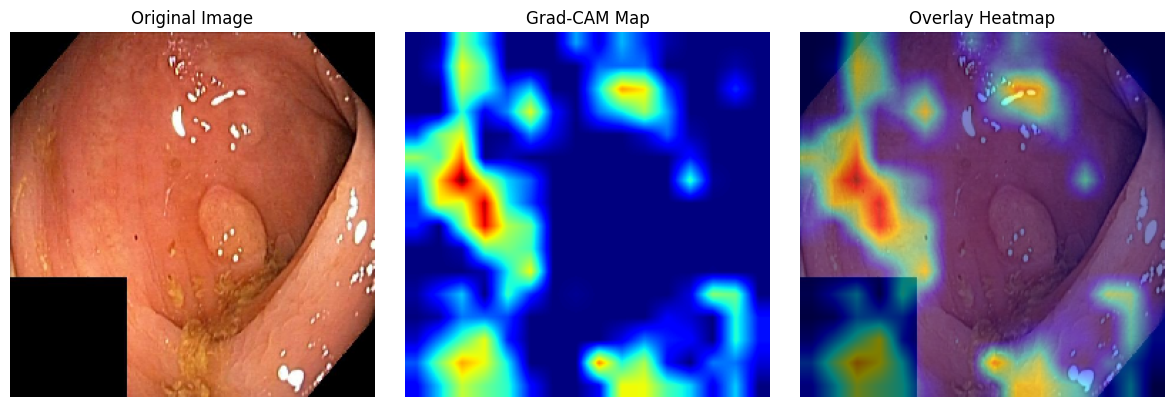

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB


image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize


heatmap = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))

# heatmap on original image with some transparency
alpha = 0.5
overlay = heatmap / 255.0 * alpha + image_np * (1 - alpha)
overlay = np.clip(overlay, 0, 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(grad_cam_map, cmap='jet')
plt.title("Grad-CAM Map")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay Heatmap")
plt.axis('off')

plt.tight_layout()
plt.show()
